Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Using real-time data augmentation.
Epoch 1/50
391/391 [==============================] - 30s 76ms/step - loss: 1.5228 - accuracy: 0.4435 - val_loss: 1.1661 - val_accuracy: 0.5835
Epoch 2/50
391/391 [==============================] - 23s 60ms/step - loss: 1.1791 - accuracy: 0.5792 - val_loss: 1.0732 - val_accuracy: 0.6221
Epoch 3/50
391/391 [==============================] - 23s 59ms/step - loss: 1.0508 - accuracy: 0.6261 - val_loss: 0.9127 - val_accuracy: 0.6774
Epoch 4/50
391/391 [==============================] - 23s 59ms/step - loss: 0.9828 - accuracy: 0.6522 - val_loss: 0.9003 - val_accuracy: 0.6833
Epoch 5/50
391/391 [==============================] - 23s 59ms/step - loss: 0.9234 - accuracy: 0.6732 - val_loss: 0.8561 - val_accuracy: 0.6997
Epoch 6/50
391/391 [==============================] - 23s 60ms/step - loss: 0.8747 - accuracy: 0.6902 - val_loss: 0.79

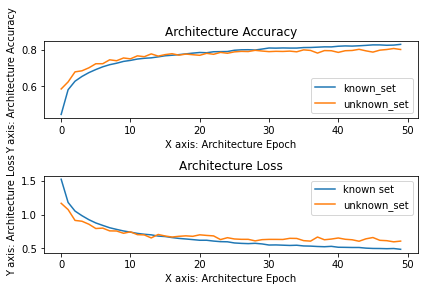

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping


batch_size = 128
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20

start= time.time()
#importing data
(train_data,train_label), (test_data,test_label)= cifar10.load_data()
print(train_data.shape,train_label.shape, test_data.shape, test_label.shape)


# Preprocessing
train_data=( train_data.astype('float') )
test_data=( test_data.astype('float') )
train_data /= 255.0
test_data /= 255.0

# Normalizing data
# Calculating mean image 
mean_image = np.mean(train_data, axis=0) 
# Calculating standard deviation 
std = np.std(train_data, axis=0)  

# Subtracting calculated mean image from datasets
train_data -= mean_image
test_data -= mean_image

# Dividing then every dataset by standard deviation
train_data /= std
test_data /= std

# Convert class vectors to binary class matrices.
train_label = keras.utils.to_categorical(train_label, num_classes)
test_label = keras.utils.to_categorical(test_label, num_classes)

#model making
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# optimizer
model.compile(loss='categorical_crossentropy',optimizer='Adam' ,metrics=['accuracy'])


#data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(train_data, train_label,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(test_label, test_label),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0,  # set range for random shear
        zoom_range=0,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_data)

    # Fit the model on the batches generated by datagen.flow().
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    history = model.fit_generator(datagen.flow(train_data, train_label,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(test_data, test_label),callbacks=[es],
                        workers=4)

# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '32_64_256_128_final_acc_77.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(test_data, test_label, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

model.summary()


#Plot
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Architecture Accuracy')
plt.ylabel('Y axis: Architecture Accuracy')
plt.xlabel('X axis: Architecture Epoch')
plt.legend(['known_set', 'unknown_set'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Architecture Loss')
plt.ylabel('Y axis: Architecture Loss')
plt.xlabel('X axis: Architecture Epoch')
plt.legend(['known set', 'unknown_set'], loc='upper right')

plt.tight_layout()
end=time.time()
print('Total Time:', end- start)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Using real-time data augmentation.
Epoch 1/50
391/391 [==============================] - 26s 67ms/step - loss: 1.5289 - accuracy: 0.4471 - val_loss: 1.1828 - val_accuracy: 0.5739
Epoch 2/50
391/391 [==============================] - 25s 65ms/step - loss: 1.1959 - accuracy: 0.5744 - val_loss: 1.1293 - val_accuracy: 0.5988
Epoch 3/50
391/391 [==============================] - 25s 65ms/step - loss: 1.0644 - accuracy: 0.6221 - val_loss: 0.9488 - val_accuracy: 0.6651
Epoch 4/50
391/391 [==============================] - 25s 65ms/step - loss: 0.9805 - accuracy: 0.6551 - val_loss: 0.8976 - val_accuracy: 0.6852
Epoch 5/50
391/391 [==============================] - 25s 65ms/step - loss: 0.9132 - accuracy: 0.6782 - val_loss: 0.8500 - val_accuracy: 0.6994
Epoch 6/50
391/391 [==============================] - 25s 65ms/step - loss: 0.8718 - accuracy: 0.6932 - val_loss: 0.7834 - val_accuracy: 0.7231
Epoch 7/50
391/391 [=====================

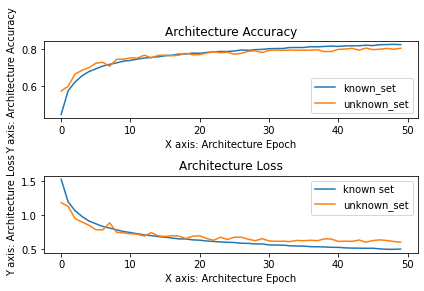

In [4]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping


batch_size = 128
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20

start= time.time()
#importing data
(train_data,train_label), (test_data,test_label)= cifar10.load_data()
print(train_data.shape,train_label.shape, test_data.shape, test_label.shape)


# Preprocessing
train_data=( train_data.astype('float') )
test_data=( test_data.astype('float') )
train_data /= 255.0
test_data /= 255.0

# Normalizing data
# Calculating mean image 
mean_image = np.mean(train_data, axis=0) 
# Calculating standard deviation 
std = np.std(train_data, axis=0)  

# Subtracting calculated mean image from datasets
train_data -= mean_image
test_data -= mean_image

# Dividing then every dataset by standard deviation
train_data /= std
test_data /= std

# Convert class vectors to binary class matrices.
train_label = keras.utils.to_categorical(train_label, num_classes)
test_label = keras.utils.to_categorical(test_label, num_classes)

#model making
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# optimizer
model.compile(loss='categorical_crossentropy',optimizer='Adam' ,metrics=['accuracy'])


#data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(train_data, train_label,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(test_label, test_label),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_data)

    # Fit the model on the batches generated by datagen.flow().
    # patient early stopping
    history = model.fit_generator(datagen.flow(train_data, train_label,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(test_data, test_label),
                        workers=4)

# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ACC80%_for_32_64_batch128.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(test_data, test_label, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

model.summary()


#Plot
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Architecture Accuracy')
plt.ylabel('Y axis: Architecture Accuracy')
plt.xlabel('X axis: Architecture Epoch')
plt.legend(['known_set', 'unknown_set'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Architecture Loss')
plt.ylabel('Y axis: Architecture Loss')
plt.xlabel('X axis: Architecture Epoch')
plt.legend(['known set', 'unknown_set'], loc='upper right')

plt.tight_layout()
end=time.time()
print('Total Time:', end- start)

In [5]:
# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ACC80%_for_32_64_batch128.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/ACC80%_for_32_64_batch128.h5 


In [6]:
from keras.models import load_model
#new_model=load_model('/content/saved_models/acc_77.59_keras_cifar10_trained_model.h5')
new_model1=load_model('/content/saved_models/ACC80%_for_32_64_batch128.h5')
new_model1.summary()
    
    
# Score trained model.
scores = new_model1.evaluate(test_data, test_label, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              